<h1 align='center'>Classification Animal Face</h1>
<h1 align='center'>SIFT In Open CV (Scale-Invariant Feature Transform)</h1>

# Download Data From Driver

In [7]:
%cd '/content'
!gdown https://drive.google.com/uc?id=1uG05PyClwmZWgxYdUFztDYUB7GMZ8L-a

/content
Downloading...
From: https://drive.google.com/uc?id=1uG05PyClwmZWgxYdUFztDYUB7GMZ8L-a
To: /content/Animal Face Dataset.zip
100% 127M/127M [00:01<00:00, 109MB/s] 


In [ ]:
!unzip '/content/Animal Face Dataset.zip'

# Install OpenCV 4.4.0

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 53 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Import Libary

In [2]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Statistics and Data Processing

In [25]:
labels = os.listdir('/content/Animal Face Dataset')
source_path = '/content/Animal Face Dataset'
join = os.path.join

In [9]:
# Hàm lấy link từng ảnh
def getLink(path):
  ans = []
  label = []
  index = 0
  list_folder = [join(path, f) for f in os.listdir(path)]

  for f in list_folder:
    list_img = [join(f, img) for img in os.listdir(f)]
    for img_link in list_img:
      ans.append(img_link)
      label.append(index)
    index += 1
  return ans, label

In [12]:
img_paths = [] # Chứa link đến từng ảnh
labels = [] # Chứa label từng ảnh
img_paths, labels = getLink("/content/Animal Face Dataset")

# Use SIFT to Feature Selection

In [ ]:
def CalcFeatures(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des

In [ ]:
features = []
i = 1
for f in img_paths:
  img = cv2.imread(f)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_des = CalcFeatures(gray)
  if img_des is not None:
    features.append(img_des)
  print(i)
  i+=1

In [ ]:
features

In [ ]:
features_ = np.vstack(features)
len(features_)

3545056

# Use K-Means Clustering

In [ ]:
# K-Means clustering is then performed on the feature array obtained from the previous step. 
# The centres obtained after clustering are further used for bagging of features.
k = 1000
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels_, centres = cv2.kmeans(features_, k, None, criteria, 10, flags)

# Bag of Features

In [ ]:
def bag_of_features(features, centres, k = 1000):
      vec = np.zeros((1, k))
      for i in range(features.shape[0]):
          feat = features[i]
          diff = np.tile(feat, (k, 1)) - centres
          dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
          idx_dist = dist.argsort()
          idx = idx_dist[0]
          vec[0][idx] += 1
      return vec

In [ ]:
vec = []
for f in img_paths:
  img = cv2.imread(f)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_des = CalcFeatures(gray)
  if img_des is not None:
    img_vec = bag_of_features(img_des, centres, k)
    vec.append(img_vec)

In [ ]:
vec_ = np.vstack(vec)
vec_

array([[0., 0., 1., ..., 0., 1., 3.],
       [0., 0., 2., ..., 4., 0., 4.],
       [0., 0., 0., ..., 1., 0., 3.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [2., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 2.]])

## Load data vec from drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [13]:
vec_ = pd.read_csv("/gdrive/MyDrive/Features_vec/vec.csv")

2763

# Split Data: Train, Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(vec_, labels, test_size = 0.2)

# Training and Evaluation Model

## Function Plot Confusion Matrix

In [15]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model Support Vector Machine (SVM)

In [28]:
from sklearn import svm
model_SVM = svm.SVC()
model_SVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_predict = model_SVM.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cnf_matrix = confusion_matrix(y_test, y_predict)

              precision    recall  f1-score   support

         dog       0.62      0.71      0.66       107
         fox       0.64      0.59      0.61        94
        lion       0.87      0.84      0.85        94
        wolf       0.62      0.68      0.65        96
       tiger       0.86      0.82      0.84        85
         cat       0.81      0.70      0.75        77

    accuracy                           0.72       553
   macro avg       0.74      0.72      0.73       553
weighted avg       0.73      0.72      0.72       553



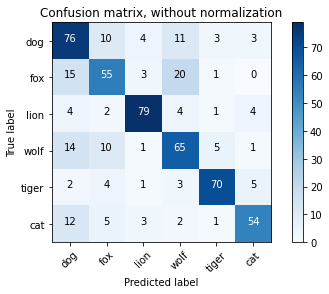

In [30]:
# classes_name = os.listdir('/content/Animal Face Dataset')
classes_name = ["dog", "fox", "lion", "wolf", "tiger", "cat"]
print(classification_report(y_test, y_predict, target_names=classes_name))
plot_confusion_matrix(cnf_matrix, classes=classes_name, title='Confusion matrix, without normalization')

## Model Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_predict = logistic_regression_model.predict(X_test)

              precision    recall  f1-score   support

         dog       0.70      0.76      0.73       107
         fox       0.58      0.52      0.55        94
        lion       0.74      0.81      0.77        94
        wolf       0.52      0.59      0.56        96
       tiger       0.85      0.67      0.75        85
         cat       0.76      0.73      0.74        77

    accuracy                           0.68       553
   macro avg       0.69      0.68      0.68       553
weighted avg       0.69      0.68      0.68       553



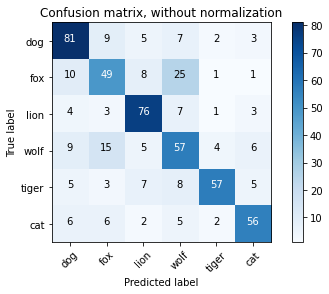

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_predict, target_names=classes_name))

cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes_name, title='Confusion matrix, without normalization')